In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment-prediction-on-movie-reviews/movies.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/sample.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv


In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Perceptron, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, ShuffleSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression

In [3]:
train = pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv')
train.head()

,movieid,reviewerName,isFrequentReviewer,reviewText,sentiment
0,marvelous_pirate,Benjamin Henry,False,Henry Selick’s first movie since 2009’s Corali...,POSITIVE
1,tony_montana_frodo_baggins_v_rocky_balboa,Felicia Lopez,False,With a cast that reads like the Vogue Oscar pa...,NEGATIVE
2,darth_vader_katniss_everdeen_sorcerer_donnie_d...,Mr. Charles Burgess,True,Creed II does not give us anything but another...,POSITIVE
3,lara_croft_glimmer,Ryan Barrett,False,"I know what you're thinking, but this is no Li...",POSITIVE
4,jason_bourne_surreal_the_terminator_indiana_jones,Alexander Glover,False,Director Fernando Meirelles tells the story wi...,POSITIVE


In [4]:
X_train = train.drop(['movieid','reviewerName','sentiment'], axis=1)
y_train=train.sentiment
y_train = LabelEncoder().fit_transform(y_train)
y_train[:5]

array([1, 0, 1, 1, 1])

In [5]:
X_train['isFrequentReviewer'] = X_train['isFrequentReviewer'].astype(str)
si_isFrequentReviewer = SimpleImputer(strategy='most_frequent', missing_values='nan').fit(X_train['isFrequentReviewer'].array.reshape(-1,1))
X_train.isFrequentReviewer = si_isFrequentReviewer.transform(X_train['isFrequentReviewer'].array.reshape(-1,1))
# label encoder - on "isFrequentReviewer"
le_isFrequentReviewer = LabelEncoder().fit(X_train.isFrequentReviewer)
X_train.isFrequentReviewer = le_isFrequentReviewer.transform(X_train.isFrequentReviewer)
X_train.fillna('', inplace=True)
X_train.head()

,isFrequentReviewer,reviewText
0,0,Henry Selick’s first movie since 2009’s Corali...
1,0,With a cast that reads like the Vogue Oscar pa...
2,1,Creed II does not give us anything but another...
3,0,"I know what you're thinking, but this is no Li..."
4,0,Director Fernando Meirelles tells the story wi...


In [6]:
X_train.isna().sum()

isFrequentReviewer    0
reviewText            0
dtype: int64

In [7]:
TextProcessor = Pipeline(steps=[
    ("squeez", FunctionTransformer(lambda x: x.squeeze())),
    ("tfidf", TfidfVectorizer(max_features = 10000,stop_words ='english')),
    ("toarray", FunctionTransformer(lambda x: x.toarray())),
])


ct = ColumnTransformer([
    ('reviewText', TextProcessor, ['reviewText']),
],
    remainder='passthrough'
)

# best_alpha = grid_search.best_params_['multinomial__alpha'] # from HPT

clf_logisticregression = Pipeline(steps=[
    ('ct',ct),
    ('minmax', MinMaxScaler()),
    ('chi', SelectKBest(chi2, k='all')),
    ('logisticregression', LogisticRegression(penalty='l2',random_state =42,solver='saga' ))
])
clf_logisticregression

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('reviewText',
                                                  Pipeline(steps=[('squeez',
                                                                   FunctionTransformer(func=<function <lambda> at 0x79721e69fd00>)),
                                                                  ('tfidf',
                                                                   TfidfVectorizer(max_features=10000,
                                                                                   stop_words='english')),
                                                                  ('toarray',
                                                                   FunctionTransformer(func=<function <lambda> at 0x79721e69fbe0>))]),
                                                  ['reviewText'])])),
                ('minmax', MinMaxScaler()),
                ('chi',
                 SelectKBest(k='all',
                             score_func=<function chi2 at 0x797224af7010>)),
                ('logisticregression',
                 LogisticRegression(random_state=42, solver='saga'))])

In [8]:
clf_logisticregression.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('reviewText',
                                                  Pipeline(steps=[('squeez',
                                                                   FunctionTransformer(func=<function <lambda> at 0x79721e69fd00>)),
                                                                  ('tfidf',
                                                                   TfidfVectorizer(max_features=10000,
                                                                                   stop_words='english')),
                                                                  ('toarray',
                                                                   FunctionTransformer(func=<function <lambda> at 0x79721e69fbe0>))]),
                                                  ['reviewText'])])),
                ('minmax', MinMaxScaler()),
                ('chi',
                 SelectKBest(k='all',
                             score_func=<function chi2 at 0x797224af7010>)),
                ('logisticregression',
                 LogisticRegression(random_state=42, solver='saga'))])

In [9]:
print(clf_logisticregression.score(X_train, y_train))

0.8186940119686897


In [10]:
TextProcessor = Pipeline(steps=[
    ("squeez", FunctionTransformer(lambda x: x.squeeze())),
    ("tfidf", TfidfVectorizer(max_features = 10000,stop_words ='english')),
    ("toarray", FunctionTransformer(lambda x: x.toarray())),
])


ct = ColumnTransformer([
    ('reviewText', TextProcessor, ['reviewText']),
],
    remainder='passthrough'
)

# best_alpha = grid_search.best_params_['multinomial__alpha'] # from HPT

clf_multinomial_HPTuned = Pipeline(steps=[
    ('ct',ct),
    ('minmax', MinMaxScaler()),
    ('chi', SelectKBest(chi2, k='all')),
    ('multinomial', MultinomialNB(alpha=1.5))
])
clf_multinomial_HPTuned

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('reviewText',
                                                  Pipeline(steps=[('squeez',
                                                                   FunctionTransformer(func=<function <lambda> at 0x79721e534310>)),
                                                                  ('tfidf',
                                                                   TfidfVectorizer(max_features=10000,
                                                                                   stop_words='english')),
                                                                  ('toarray',
                                                                   FunctionTransformer(func=<function <lambda> at 0x79721e5345e0>))]),
                                                  ['reviewText'])])),
                ('minmax', MinMaxScaler()),
                ('chi',
                 SelectKBest(k='all',
                             score_func=<function chi2 at 0x797224af7010>)),
                ('multinomial', MultinomialNB(alpha=1.5))])

In [11]:
# clf_multinomial_HPTuned.fit(X_train, y_train)

In [12]:
# print(clf_multinomial_HPTuned.score(X_train, y_train))

In [13]:
TextProcessor = Pipeline(steps=[
    ("squeez", FunctionTransformer(lambda x: x.squeeze())),
    ("tfidf", TfidfVectorizer(max_features = 5000,stop_words ='english')),
    ("toarray", FunctionTransformer(lambda x: x.toarray())),
])


ct = ColumnTransformer([
    ('reviewText', TextProcessor, ['reviewText']),
],
    remainder='passthrough'
)

clf_RandomForestClassifier = Pipeline(steps=[
    ('ct',ct),
    ('minmax', MinMaxScaler()),
    ('chi', SelectKBest(chi2, k=5000)),
    ('multinomial', RandomForestClassifier())
])
clf_RandomForestClassifier

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('reviewText',
                                                  Pipeline(steps=[('squeez',
                                                                   FunctionTransformer(func=<function <lambda> at 0x7972244afb50>)),
                                                                  ('tfidf',
                                                                   TfidfVectorizer(max_features=5000,
                                                                                   stop_words='english')),
                                                                  ('toarray',
                                                                   FunctionTransformer(func=<function <lambda> at 0x79721e534550>))]),
                                                  ['reviewText'])])),
                ('minmax', MinMaxScaler()),
                ('chi',
                 SelectKBest(k=5000,
                             score_func=<function chi2 at 0x797224af7010>)),
                ('multinomial', RandomForestClassifier())])

In [14]:
# clf_RandomForestClassifier.fit(X_train,y_train)

In [15]:
# print(clf_RandomForestClassifier.score(X_train, y_train))

In [16]:
TextProcessor = Pipeline(steps=[
    ("squeez", FunctionTransformer(lambda x: x.squeeze())),
    ("tfidf", TfidfVectorizer(stop_words ='english')),
    ("toarray", FunctionTransformer(lambda x: x.toarray())),
])


ct = ColumnTransformer([
    ('reviewText', TextProcessor, ['reviewText']),
],
    remainder='passthrough'
)

clf_DecisionTreeClassifier = Pipeline(steps=[
    ('ct',ct),
    ('minmax', MinMaxScaler()),
    ('chi', SelectKBest(chi2, k=5000)),
    ('multinomial', DecisionTreeClassifier(
                                            max_depth=5,
                                            min_samples_split=2,
                                            min_samples_leaf=1,
                                            min_impurity_decrease=0.0,
                                            ccp_alpha=0.0,
                                            random_state=42
                                            ))
])
clf_DecisionTreeClassifier

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('reviewText',
                                                  Pipeline(steps=[('squeez',
                                                                   FunctionTransformer(func=<function <lambda> at 0x79721e5344c0>)),
                                                                  ('tfidf',
                                                                   TfidfVectorizer(stop_words='english')),
                                                                  ('toarray',
                                                                   FunctionTransformer(func=<function <lambda> at 0x79721e534700>))]),
                                                  ['reviewText'])])),
                ('minmax', MinMaxScaler()),
                ('chi',
                 SelectKBest(k=5000,
                             score_func=<function chi2 at 0x797224af7010>)),
                ('multinomial',
                 DecisionTreeClassifier(max_depth=5, random_state=42))])

In [17]:
# clf_DecisionTreeClassifier.fit(X_train,y_train)

In [18]:
# print(clf_DecisionTreeClassifier.score(X_train, y_train))

# 1. MERGING train and movies DATASETS, MANIPULATION & CLEANING
### 1.1 converting date to month and day of week for "releaseDateTheaters" and "releaseDateStreaming" columns


### 1.2 REMOVING FEATUREs
##### movieid                  : superkey
##### title                    : additional-key
##### ratingContent            : expansion of rating column
##### releaseDateTheaters      : taken out usefull information - relaseDateTheater_month, .._dayofweek
##### releaseDateStreaming     : taken out usefull information - relaseDateStreaming_month, .._dayofweek
##### releaseDateTheaters_pd   : was created for finding month and dayof week
##### releaseDateStreaming_pd   : was created for finding month and dayof week
##### reviewerName              : ---
##### boxOffice                 : has 90% is null
##### rating                    : has 90% is null
##### director                  : ---
##### distributor               : has 84% is null
##### soundType                 : has 89% is null

In [19]:
def prepare_the_data(data):
    movies = pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews/movies.csv')
    movies = movies.drop_duplicates()
    movies = movies.drop_duplicates(subset=['movieid'])
    
    train_merged = data.merge(movies, on='movieid', how='left')
    
    train_merged['releaseDateTheaters_pd'] = pd.to_datetime(train_merged.releaseDateTheaters)
    train_merged['releaseDateTheaters_month'] = train_merged['releaseDateTheaters_pd'].dt.month
    train_merged['releaseDateTheaters_dayofweek'] = train_merged['releaseDateTheaters_pd'].dt.dayofweek

    train_merged['releaseDateStreaming_pd'] = pd.to_datetime(train_merged.releaseDateTheaters)
    train_merged['releaseDateStreaming_month'] = train_merged['releaseDateStreaming_pd'].dt.month
    train_merged['releaseDateStreaming_dayofweek'] = train_merged['releaseDateStreaming_pd'].dt.dayofweek
    
    train_merged = train_merged.drop(['movieid','title','ratingContents','releaseDateTheaters', 'releaseDateStreaming',
                                 'releaseDateTheaters_pd','releaseDateStreaming_pd','reviewerName','boxOffice', 'rating', 'director',
                                 'distributor','soundType'], axis=1)
    
    return train_merged

In [20]:
train_merged = prepare_the_data(train)

In [21]:
y = LabelEncoder().fit_transform(train_merged.sentiment)
X = train_merged.drop(['sentiment'], axis=1)
print(X.shape)
print(y.shape)

(162758, 10)
(162758,)


In [22]:
from sklearn.model_selection import train_test_split
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.33, random_state=42)

# 3. PREPROCESSING

In [23]:
# def column_transformer(X_train):
#     ##isFrequentReviewer
#     # simple imputer - most_frequent on "isFrequentReviewer"
#     X_train['isFrequentReviewer'] = X_train['isFrequentReviewer'].astype(str)
#     si_isFrequentReviewer = SimpleImputer(strategy='most_frequent', missing_values='nan').fit(X_train['isFrequentReviewer'].array.reshape(-1,1))
#     X_train.isFrequentReviewer = si_isFrequentReviewer.transform(X_train['isFrequentReviewer'].array.reshape(-1,1))
#     # label encoder - on "isFrequentReviewer"
#     le_isFrequentReviewer = LabelEncoder().fit(X_train.isFrequentReviewer)
#     X_train.isFrequentReviewer = le_isFrequentReviewer.transform(X_train.isFrequentReviewer)
    
#     ##audienceScore
#     # simple imputer - mean on "audienceScore"
#     si_audienceScore = SimpleImputer(strategy='mean').fit(X_train['audienceScore'].array.reshape(-1,1))
#     X_train.audienceScore = si_audienceScore.transform(X_train['audienceScore'].array.reshape(-1,1))
    
#     ##runtimeMinutes
#     # simple imputer - mean on "runtimeMinutes"
#     si_runtimeMinutes = SimpleImputer(strategy='mean').fit(X_train['runtimeMinutes'].array.reshape(-1,1))
#     X_train.runtimeMinutes = si_runtimeMinutes.transform(X_train['runtimeMinutes'].array.reshape(-1,1))
    
#     ##genre
#     # simple imputer - most_frequent on "genre"
#     si_genre = SimpleImputer(strategy='most_frequent').fit(X_train['genre'].array.reshape(-1,1))
#     X_train.genre = si_genre.transform(X_train['genre'].array.reshape(-1,1))
    
#     ##originalLanguage
#     # simple imputer - most_frequent on "originalLanguage"
#     si_originalLanguage = SimpleImputer(strategy='most_frequent').fit(X_train['originalLanguage'].array.reshape(-1,1))
#     X_train.originalLanguage = si_originalLanguage.transform(X_train['originalLanguage'].array.reshape(-1,1))
    
#     ##releaseDateTheaters_month
#     # simple imputer - most_frequent on "releaseDateTheaters_month"
#     si_releaseDateTheaters_month = SimpleImputer(strategy='most_frequent').fit(X_train['releaseDateTheaters_month'].array.reshape(-1,1))
#     X_train.releaseDateTheaters_month = si_releaseDateTheaters_month.transform(X_train['releaseDateTheaters_month'].array.reshape(-1,1))
    
#     ##releaseDateTheaters_dayofweek
#     # simple imputer - most_frequent on "releaseDateTheaters_dayofweek"
#     si_releaseDateTheaters_dayofweek = SimpleImputer(strategy='most_frequent').fit(X_train['releaseDateTheaters_dayofweek'].array.reshape(-1,1))
#     X_train.releaseDateTheaters_dayofweek = si_releaseDateTheaters_dayofweek.transform(X_train['releaseDateTheaters_dayofweek'].array.reshape(-1,1))
    
#     ##releaseDateStreaming_month
#     # simple imputer - most_frequent on "releaseDateStreaming_month"
#     si_releaseDateStreaming_month = SimpleImputer(strategy='most_frequent').fit(X_train['releaseDateStreaming_month'].array.reshape(-1,1))
#     X_train.releaseDateStreaming_month = si_releaseDateStreaming_month.transform(X_train['releaseDateStreaming_month'].array.reshape(-1,1))
    
#     ##releaseDateStreaming_dayofweek
#     # simple imputer - most_frequent on "releaseDateStreaming_dayofweek"
#     si_releaseDateStreaming_dayofweek = SimpleImputer(strategy='most_frequent').fit(X_train['releaseDateStreaming_dayofweek'].array.reshape(-1,1))
#     X_train.releaseDateStreaming_dayofweek = si_releaseDateStreaming_dayofweek.transform(X_train['releaseDateStreaming_dayofweek'].array.reshape(-1,1))
    
#     X_train.fillna('', inplace=True)
#     X_train['reviewText_genre_originalLanguage'] = X_train['reviewText'].astype(str) + " " + X_train['genre'].astype(str) + " " + X_train['originalLanguage'].astype(str)
#     X_train = X_train.drop(['reviewText','genre','originalLanguage'], axis=1)
#     return X_train

# X_train = column_transformer(X_train)
# X_validate = column_transformer(X_validate)
# # X_train.head()

In [24]:
##isFrequentReviewer
# simple imputer - most_frequent on "isFrequentReviewer"
X_train['isFrequentReviewer'] = X_train['isFrequentReviewer'].astype(str)
si_isFrequentReviewer = SimpleImputer(strategy='most_frequent', missing_values='nan').fit(X_train['isFrequentReviewer'].array.reshape(-1,1))
X_train.isFrequentReviewer = si_isFrequentReviewer.transform(X_train['isFrequentReviewer'].array.reshape(-1,1))
# label encoder - on "isFrequentReviewer"
le_isFrequentReviewer = LabelEncoder().fit(X_train.isFrequentReviewer)
X_train.isFrequentReviewer = le_isFrequentReviewer.transform(X_train.isFrequentReviewer)

##audienceScore
# simple imputer - mean on "audienceScore"
si_audienceScore = SimpleImputer(strategy='mean').fit(X_train['audienceScore'].array.reshape(-1,1))
X_train.audienceScore = si_audienceScore.transform(X_train['audienceScore'].array.reshape(-1,1))

##runtimeMinutes
# simple imputer - mean on "runtimeMinutes"
si_runtimeMinutes = SimpleImputer(strategy='mean').fit(X_train['runtimeMinutes'].array.reshape(-1,1))
X_train.runtimeMinutes = si_runtimeMinutes.transform(X_train['runtimeMinutes'].array.reshape(-1,1))

##genre
# simple imputer - most_frequent on "genre"
si_genre = SimpleImputer(strategy='most_frequent').fit(X_train['genre'].array.reshape(-1,1))
X_train.genre = si_genre.transform(X_train['genre'].array.reshape(-1,1))

##originalLanguage
# simple imputer - most_frequent on "originalLanguage"
si_originalLanguage = SimpleImputer(strategy='most_frequent').fit(X_train['originalLanguage'].array.reshape(-1,1))
X_train.originalLanguage = si_originalLanguage.transform(X_train['originalLanguage'].array.reshape(-1,1))

##releaseDateTheaters_month
# simple imputer - most_frequent on "releaseDateTheaters_month"
si_releaseDateTheaters_month = SimpleImputer(strategy='most_frequent').fit(X_train['releaseDateTheaters_month'].array.reshape(-1,1))
X_train.releaseDateTheaters_month = si_releaseDateTheaters_month.transform(X_train['releaseDateTheaters_month'].array.reshape(-1,1))

##releaseDateTheaters_dayofweek
# simple imputer - most_frequent on "releaseDateTheaters_dayofweek"
si_releaseDateTheaters_dayofweek = SimpleImputer(strategy='most_frequent').fit(X_train['releaseDateTheaters_dayofweek'].array.reshape(-1,1))
X_train.releaseDateTheaters_dayofweek = si_releaseDateTheaters_dayofweek.transform(X_train['releaseDateTheaters_dayofweek'].array.reshape(-1,1))

##releaseDateStreaming_month
# simple imputer - most_frequent on "releaseDateStreaming_month"
si_releaseDateStreaming_month = SimpleImputer(strategy='most_frequent').fit(X_train['releaseDateStreaming_month'].array.reshape(-1,1))
X_train.releaseDateStreaming_month = si_releaseDateStreaming_month.transform(X_train['releaseDateStreaming_month'].array.reshape(-1,1))

##releaseDateStreaming_dayofweek
# simple imputer - most_frequent on "releaseDateStreaming_dayofweek"
si_releaseDateStreaming_dayofweek = SimpleImputer(strategy='most_frequent').fit(X_train['releaseDateStreaming_dayofweek'].array.reshape(-1,1))
X_train.releaseDateStreaming_dayofweek = si_releaseDateStreaming_dayofweek.transform(X_train['releaseDateStreaming_dayofweek'].array.reshape(-1,1))

X_train.fillna('', inplace=True)
X_train['reviewText_genre_originalLanguage'] = X_train['reviewText'].astype(str) + " " + X_train['genre'].astype(str) + " " + X_train['originalLanguage'].astype(str)
X_train = X_train.drop(['reviewText','genre','originalLanguage'], axis=1)

In [25]:
##isFrequentReviewer
# simple imputer - most_frequent on "isFrequentReviewer"
X_validate['isFrequentReviewer'] = X_validate['isFrequentReviewer'].astype(str)
### si_isFrequentReviewer = SimpleImputer(strategy='most_frequent', missing_values='nan').fit(X_train['isFrequentReviewer'].array.reshape(-1,1))
X_validate.isFrequentReviewer = si_isFrequentReviewer.transform(X_validate['isFrequentReviewer'].array.reshape(-1,1))
# label encoder - on "isFrequentReviewer"
### le_isFrequentReviewer = LabelEncoder().fit(X_validate.isFrequentReviewer)
X_validate.isFrequentReviewer = le_isFrequentReviewer.transform(X_validate.isFrequentReviewer)

##audienceScore
# simple imputer - mean on "audienceScore"
### si_audienceScore = SimpleImputer(strategy='mean').fit(X_validate['audienceScore'].array.reshape(-1,1))
X_validate.audienceScore = si_audienceScore.transform(X_validate['audienceScore'].array.reshape(-1,1))

##runtimeMinutes
# simple imputer - mean on "runtimeMinutes"
### si_runtimeMinutes = SimpleImputer(strategy='mean').fit(X_validate['runtimeMinutes'].array.reshape(-1,1))
X_validate.runtimeMinutes = si_runtimeMinutes.transform(X_validate['runtimeMinutes'].array.reshape(-1,1))

##genre
# simple imputer - most_frequent on "genre"
### si_genre = SimpleImputer(strategy='most_frequent').fit(X_validate['genre'].array.reshape(-1,1))
X_validate.genre = si_genre.transform(X_validate['genre'].array.reshape(-1,1))

##originalLanguage
# simple imputer - most_frequent on "originalLanguage"
### si_originalLanguage = SimpleImputer(strategy='most_frequent').fit(X_validate['originalLanguage'].array.reshape(-1,1))
X_validate.originalLanguage = si_originalLanguage.transform(X_validate['originalLanguage'].array.reshape(-1,1))

##releaseDateTheaters_month
# simple imputer - most_frequent on "releaseDateTheaters_month"
### si_releaseDateTheaters_month = SimpleImputer(strategy='most_frequent').fit(X_validate['releaseDateTheaters_month'].array.reshape(-1,1))
X_validate.releaseDateTheaters_month = si_releaseDateTheaters_month.transform(X_validate['releaseDateTheaters_month'].array.reshape(-1,1))

##releaseDateTheaters_dayofweek
# simple imputer - most_frequent on "releaseDateTheaters_dayofweek"
### si_releaseDateTheaters_dayofweek = SimpleImputer(strategy='most_frequent').fit(X_validate['releaseDateTheaters_dayofweek'].array.reshape(-1,1))
X_validate.releaseDateTheaters_dayofweek = si_releaseDateTheaters_dayofweek.transform(X_validate['releaseDateTheaters_dayofweek'].array.reshape(-1,1))

##releaseDateStreaming_month
# simple imputer - most_frequent on "releaseDateStreaming_month"
### si_releaseDateStreaming_month = SimpleImputer(strategy='most_frequent').fit(X_validate['releaseDateStreaming_month'].array.reshape(-1,1))
X_validate.releaseDateStreaming_month = si_releaseDateStreaming_month.transform(X_validate['releaseDateStreaming_month'].array.reshape(-1,1))

##releaseDateStreaming_dayofweek
# simple imputer - most_frequent on "releaseDateStreaming_dayofweek"
### si_releaseDateStreaming_dayofweek = SimpleImputer(strategy='most_frequent').fit(X_validate['releaseDateStreaming_dayofweek'].array.reshape(-1,1))
X_validate.releaseDateStreaming_dayofweek = si_releaseDateStreaming_dayofweek.transform(X_validate['releaseDateStreaming_dayofweek'].array.reshape(-1,1))

X_validate.fillna('', inplace=True)
X_validate['reviewText_genre_originalLanguage'] = X_validate['reviewText'].astype(str) + " " + X_validate['genre'].astype(str) + " " + X_validate['originalLanguage'].astype(str)
X_validate = X_validate.drop(['reviewText','genre','originalLanguage'], axis=1)

In [26]:
a = pd.DataFrame(X_train)
b = pd.DataFrame(y_train)
joined_df = pd.concat([a, b], axis=1)

/tmp/ipykernel_20/695129891.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(joined_df.corr(), annot=True, cmap='coolwarm')


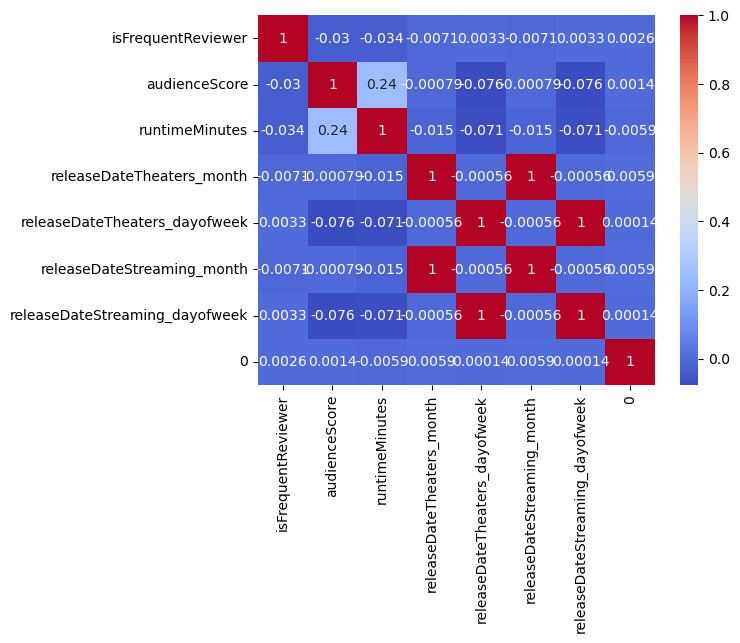

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(joined_df.corr(), annot=True, cmap='coolwarm')
plt.show()

# SGDClassifier

In [28]:
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Perceptron, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, ShuffleSplit
from sklearn.preprocessing import MinMaxScaler


TextProcessor = Pipeline(steps=[
    ("squeez", FunctionTransformer(lambda x: x.squeeze())),
    ("tfidf", TfidfVectorizer(max_features = 10000,stop_words ='english')),
    ("toarray", FunctionTransformer(lambda x: x.toarray())),
])


ct = ColumnTransformer([
    ('reviewText_genre_originalLanguage', TextProcessor, ['reviewText_genre_originalLanguage']),
],
    remainder='passthrough'
)

clf_sgdclassifier = Pipeline(steps=[
    ('ct',ct),
    ('minmax', MinMaxScaler()),
    ('chi', SelectKBest(chi2, k='all')),
    ('multinomial', SGDClassifier())
])
clf_sgdclassifier

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('reviewText_genre_originalLanguage',
                                                  Pipeline(steps=[('squeez',
                                                                   FunctionTransformer(func=<function <lambda> at 0x797221b905e0>)),
                                                                  ('tfidf',
                                                                   TfidfVectorizer(max_features=10000,
                                                                                   stop_words='english')),
                                                                  ('toarray',
                                                                   FunctionTransformer(func=<function <lambda> at 0x797221b908b0>))]),
                                                  ['reviewText_genre_originalLanguage'])])),
                ('minmax', MinMaxScaler()),
                ('chi',
                 SelectKBest(k='all',
                             score_func=<function chi2 at 0x797224af7010>)),
                ('multinomial', SGDClassifier())])

In [29]:
# clf_sgdclassifier.fit(X_train,y_train)

In [30]:
# print(clf_sgdclassifier.score(X_train, y_train))
# print(clf_sgdclassifier.score(X_validate, y_validate))

score without MinMaxScaler;
train: 0.75
validate: 0.749

score with MinMaxScaler;
train: 0.78
validate: 0.77

# Multinomial

In [31]:
TextProcessor = Pipeline(steps=[
    ("squeez", FunctionTransformer(lambda x: x.squeeze())),
    ("tfidf", TfidfVectorizer(max_features = 10000,stop_words ='english')),
    ("toarray", FunctionTransformer(lambda x: x.toarray())),
])


ct = ColumnTransformer([
    ('reviewText_genre_originalLanguage', TextProcessor, ['reviewText_genre_originalLanguage']),
],
    remainder='passthrough'
)

clf_multinomial = Pipeline(steps=[
    ('ct',ct),
    ('minmax', MinMaxScaler()),
    ('chi', SelectKBest(chi2, k='all')),
    ('multinomial', MultinomialNB())
])
clf_multinomial

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('reviewText_genre_originalLanguage',
                                                  Pipeline(steps=[('squeez',
                                                                   FunctionTransformer(func=<function <lambda> at 0x797221d81870>)),
                                                                  ('tfidf',
                                                                   TfidfVectorizer(max_features=10000,
                                                                                   stop_words='english')),
                                                                  ('toarray',
                                                                   FunctionTransformer(func=<function <lambda> at 0x797221d81990>))]),
                                                  ['reviewText_genre_originalLanguage'])])),
                ('minmax', MinMaxScaler()),
                ('chi',
                 SelectKBest(k='all',
                             score_func=<function chi2 at 0x797224af7010>)),
                ('multinomial', MultinomialNB())])

In [32]:
# clf_multinomial.fit(X_train,y_train)

In [33]:
# print(clf_multinomial.score(X_train, y_train))
# print(clf_multinomial.score(X_validate, y_validate))

score without MinMaxScaler;
train: 0.71
validate: 0.71

score with MinMaxScaler;
train: 0.78
validate: 0.77

# HPTuning for Multinomial

In [34]:
TextProcessor = Pipeline(steps=[
    ("squeez", FunctionTransformer(lambda x: x.squeeze())),
    ("tfidf", TfidfVectorizer(max_features = 10000,stop_words ='english')),
    ("toarray", FunctionTransformer(lambda x: x.toarray())),
])


ct = ColumnTransformer([
    ('reviewText_genre_originalLanguage', TextProcessor, ['reviewText_genre_originalLanguage']),
],
    remainder='passthrough'
)

clf_multinomial_GS = Pipeline(steps=[
    ('ct',ct),
    ('minmax', MinMaxScaler()),
    ('chi', SelectKBest(chi2, k='all')),
    ('multinomial', MultinomialNB())
])
clf_multinomial_GS

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('reviewText_genre_originalLanguage',
                                                  Pipeline(steps=[('squeez',
                                                                   FunctionTransformer(func=<function <lambda> at 0x797221d815a0>)),
                                                                  ('tfidf',
                                                                   TfidfVectorizer(max_features=10000,
                                                                                   stop_words='english')),
                                                                  ('toarray',
                                                                   FunctionTransformer(func=<function <lambda> at 0x797221d81a20>))]),
                                                  ['reviewText_genre_originalLanguage'])])),
                ('minmax', MinMaxScaler()),
                ('chi',
                 SelectKBest(k='all',
                             score_func=<function chi2 at 0x797224af7010>)),
                ('multinomial', MultinomialNB())])

In [35]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

scoring_metric = 'accuracy'

alpha_values = [0.1, 0.5, 1.0, 2.0]

param_grid = {'multinomial__alpha': alpha_values}
# nb_model = MultinomialNB()
grid_search = GridSearchCV(clf_multinomial_GS, param_grid, scoring=scoring_metric, cv=5)

In [36]:
# grid_search.fit(X_train, y_train)

In [37]:
# grid_search.best_params_

{'multinomial__alpha': 1.0}

In [38]:
# TextProcessor = Pipeline(steps=[
#     ("squeez", FunctionTransformer(lambda x: x.squeeze())),
#     ("tfidf", TfidfVectorizer(max_features = 10000,stop_words ='english')),
#     ("toarray", FunctionTransformer(lambda x: x.toarray())),
# ])


# ct = ColumnTransformer([
#     ('reviewText_genre_originalLanguage', TextProcessor, ['reviewText_genre_originalLanguage']),
# ],
#     remainder='passthrough'
# )

# best_alpha = grid_search.best_params_['multinomial__alpha'] # from HPT

# clf_multinomial_HPTuned = Pipeline(steps=[
#     ('ct',ct),
#     ('minmax', MinMaxScaler()),
#     ('chi', SelectKBest(chi2, k='all')),
#     ('multinomial', MultinomialNB(alpha=best_alpha))
# ])
# clf_multinomial_HPTuned

In [39]:
# clf_multinomial_HPTuned.fit(X_train, y_train)

In [40]:
# print(clf_multinomial_HPTuned.score(X_train, y_train))
# print(clf_multinomial_HPTuned.score(X_validate, y_validate))

0.805836015662971
0.7814600361192306

In [41]:
# y_pred = clf_multinomial_HPTuned.predict(X_validate)
# final_accuracy = accuracy_score(y_validate, y_validate)

# print("Best alpha:", best_alpha)
# print("Final accuracy:", final_accuracy)

Best alpha: 1.0
Final accuracy: 1.0

# Tranining MulninomialNB with HPTuned parameters 

In [42]:
X_whole = X
y_whole = y

In [43]:
##isFrequentReviewer
# simple imputer - most_frequent on "isFrequentReviewer"
X_whole['isFrequentReviewer'] = X_whole['isFrequentReviewer'].astype(str)
si_isFrequentReviewer = SimpleImputer(strategy='most_frequent', missing_values='nan').fit(X_whole['isFrequentReviewer'].array.reshape(-1,1))
X_whole.isFrequentReviewer = si_isFrequentReviewer.transform(X_whole['isFrequentReviewer'].array.reshape(-1,1))
# label encoder - on "isFrequentReviewer"
le_isFrequentReviewer = LabelEncoder().fit(X_whole.isFrequentReviewer)
X_whole.isFrequentReviewer = le_isFrequentReviewer.transform(X_whole.isFrequentReviewer)

##audienceScore
# simple imputer - mean on "audienceScore"
si_audienceScore = SimpleImputer(strategy='mean').fit(X_whole['audienceScore'].array.reshape(-1,1))
X_whole.audienceScore = si_audienceScore.transform(X_whole['audienceScore'].array.reshape(-1,1))

##runtimeMinutes
# simple imputer - mean on "runtimeMinutes"
si_runtimeMinutes = SimpleImputer(strategy='mean').fit(X_whole['runtimeMinutes'].array.reshape(-1,1))
X_whole.runtimeMinutes = si_runtimeMinutes.transform(X_whole['runtimeMinutes'].array.reshape(-1,1))

##genre
# simple imputer - most_frequent on "genre"
si_genre = SimpleImputer(strategy='most_frequent').fit(X_whole['genre'].array.reshape(-1,1))
X_whole.genre = si_genre.transform(X_whole['genre'].array.reshape(-1,1))

##originalLanguage
# simple imputer - most_frequent on "originalLanguage"
si_originalLanguage = SimpleImputer(strategy='most_frequent').fit(X_whole['originalLanguage'].array.reshape(-1,1))
X_whole.originalLanguage = si_originalLanguage.transform(X_whole['originalLanguage'].array.reshape(-1,1))

##releaseDateTheaters_month
# simple imputer - most_frequent on "releaseDateTheaters_month"
si_releaseDateTheaters_month = SimpleImputer(strategy='most_frequent').fit(X_whole['releaseDateTheaters_month'].array.reshape(-1,1))
X_whole.releaseDateTheaters_month = si_releaseDateTheaters_month.transform(X_whole['releaseDateTheaters_month'].array.reshape(-1,1))

##releaseDateTheaters_dayofweek
# simple imputer - most_frequent on "releaseDateTheaters_dayofweek"
si_releaseDateTheaters_dayofweek = SimpleImputer(strategy='most_frequent').fit(X_whole['releaseDateTheaters_dayofweek'].array.reshape(-1,1))
X_whole.releaseDateTheaters_dayofweek = si_releaseDateTheaters_dayofweek.transform(X_whole['releaseDateTheaters_dayofweek'].array.reshape(-1,1))

##releaseDateStreaming_month
# simple imputer - most_frequent on "releaseDateStreaming_month"
si_releaseDateStreaming_month = SimpleImputer(strategy='most_frequent').fit(X_whole['releaseDateStreaming_month'].array.reshape(-1,1))
X_whole.releaseDateStreaming_month = si_releaseDateStreaming_month.transform(X_whole['releaseDateStreaming_month'].array.reshape(-1,1))

##releaseDateStreaming_dayofweek
# simple imputer - most_frequent on "releaseDateStreaming_dayofweek"
si_releaseDateStreaming_dayofweek = SimpleImputer(strategy='most_frequent').fit(X_whole['releaseDateStreaming_dayofweek'].array.reshape(-1,1))
X_whole.releaseDateStreaming_dayofweek = si_releaseDateStreaming_dayofweek.transform(X_whole['releaseDateStreaming_dayofweek'].array.reshape(-1,1))

X_whole.fillna('', inplace=True)
X_whole['reviewText_genre_originalLanguage'] = X_whole['reviewText'].astype(str) + " " + X_whole['genre'].astype(str) + " " + X_whole['originalLanguage'].astype(str)
X_whole = X_whole.drop(['reviewText','genre','originalLanguage'], axis=1)

In [44]:
TextProcessor = Pipeline(steps=[
    ("squeez", FunctionTransformer(lambda x: x.squeeze())),
    ("tfidf", TfidfVectorizer(max_features = 10000,stop_words ='english')),
    ("toarray", FunctionTransformer(lambda x: x.toarray())),
])


ct = ColumnTransformer([
    ('reviewText_genre_originalLanguage', TextProcessor, ['reviewText_genre_originalLanguage']),
],
    remainder='passthrough'
)

# best_alpha = grid_search.best_params_['multinomial__alpha'] # from HPT

clf_multinomial_HPTuned = Pipeline(steps=[
    ('ct',ct),
    ('minmax', MinMaxScaler()),
    ('chi', SelectKBest(chi2, k='all')),
    ('multinomial', MultinomialNB(alpha=1.0))
])
clf_multinomial_HPTuned

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('reviewText_genre_originalLanguage',
                                                  Pipeline(steps=[('squeez',
                                                                   FunctionTransformer(func=<function <lambda> at 0x797213780af0>)),
                                                                  ('tfidf',
                                                                   TfidfVectorizer(max_features=10000,
                                                                                   stop_words='english')),
                                                                  ('toarray',
                                                                   FunctionTransformer(func=<function <lambda> at 0x797213780a60>))]),
                                                  ['reviewText_genre_originalLanguage'])])),
                ('minmax', MinMaxScaler()),
                ('chi',
                 SelectKBest(k='all',
                             score_func=<function chi2 at 0x797224af7010>)),
                ('multinomial', MultinomialNB())])

In [45]:
clf_multinomial_HPTuned.fit(X_whole, y_whole)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('reviewText_genre_originalLanguage',
                                                  Pipeline(steps=[('squeez',
                                                                   FunctionTransformer(func=<function <lambda> at 0x797213780af0>)),
                                                                  ('tfidf',
                                                                   TfidfVectorizer(max_features=10000,
                                                                                   stop_words='english')),
                                                                  ('toarray',
                                                                   FunctionTransformer(func=<function <lambda> at 0x797213780a60>))]),
                                                  ['reviewText_genre_originalLanguage'])])),
                ('minmax', MinMaxScaler()),
                ('chi',
                 SelectKBest(k='all',
                             score_func=<function chi2 at 0x797224af7010>)),
                ('multinomial', MultinomialNB())])

In [46]:
print(clf_multinomial_HPTuned.score(X_whole, y_whole))

0.8002371619213802


0.8002371619213802

# Perceptron

In [47]:
TextProcessor = Pipeline(steps=[
    ("squeez", FunctionTransformer(lambda x: x.squeeze())),
    ("tfidf", TfidfVectorizer(max_features = 5000,stop_words ='english')),
    ("toarray", FunctionTransformer(lambda x: x.toarray())),
])


ct = ColumnTransformer([
    ('reviewText_genre_originalLanguage', TextProcessor, ['reviewText_genre_originalLanguage']),
],
    remainder='passthrough'
)

clf_perceptron = Pipeline(steps=[
    ('ct',ct),
    ('minmax', MinMaxScaler()),
    ('chi', SelectKBest(chi2, k=5000)),
    ('multinomial', Perceptron())
])
clf_perceptron

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('reviewText_genre_originalLanguage',
                                                  Pipeline(steps=[('squeez',
                                                                   FunctionTransformer(func=<function <lambda> at 0x797213780940>)),
                                                                  ('tfidf',
                                                                   TfidfVectorizer(max_features=5000,
                                                                                   stop_words='english')),
                                                                  ('toarray',
                                                                   FunctionTransformer(func=<function <lambda> at 0x7972137808b0>))]),
                                                  ['reviewText_genre_originalLanguage'])])),
                ('minmax', MinMaxScaler()),
                ('chi',
                 SelectKBest(k=5000,
                             score_func=<function chi2 at 0x797224af7010>)),
                ('multinomial', Perceptron())])

In [48]:
# clf_perceptron.fit(X_train,y_train)

In [49]:
# print(clf_perceptron.score(X_train, y_train))
# print(clf_perceptron.score(X_validate, y_validate))

score without MinMaxScaler;
train: 0.539
validate: 0.534

score with MinMaxScaler;
train: 0.78
validate: 0.76

# Decisiontree

In [50]:
TextProcessor = Pipeline(steps=[
    ("squeez", FunctionTransformer(lambda x: x.squeeze())),
    ("tfidf", TfidfVectorizer(max_features = 10000,stop_words ='english')),
    ("toarray", FunctionTransformer(lambda x: x.toarray())),
])


ct = ColumnTransformer([
    ('reviewText_genre_originalLanguage', TextProcessor, ['reviewText_genre_originalLanguage']),
],
    remainder='passthrough'
)

clf_DecisionTreeClassifier = Pipeline(steps=[
    ('ct',ct),
    ('minmax', MinMaxScaler()),
    ('chi', SelectKBest(chi2, k=5000)),
    ('multinomial', DecisionTreeClassifier())
])
clf_DecisionTreeClassifier

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('reviewText_genre_originalLanguage',
                                                  Pipeline(steps=[('squeez',
                                                                   FunctionTransformer(func=<function <lambda> at 0x797213780ca0>)),
                                                                  ('tfidf',
                                                                   TfidfVectorizer(max_features=10000,
                                                                                   stop_words='english')),
                                                                  ('toarray',
                                                                   FunctionTransformer(func=<function <lambda> at 0x797213780820>))]),
                                                  ['reviewText_genre_originalLanguage'])])),
                ('minmax', MinMaxScaler()),
                ('chi',
                 SelectKBest(k=5000,
                             score_func=<function chi2 at 0x797224af7010>)),
                ('multinomial', DecisionTreeClassifier())])

In [51]:
# clf_DecisionTreeClassifier.fit(X_train,y_train)

In [52]:
# print(clf_DecisionTreeClassifier.score(X_train, y_train))
# print(clf_DecisionTreeClassifier.score(X_validate, y_validate))

Being overfitted!

score without MinMaxScaler;
train: 0.99
validate: 0.67

score with MinMaxScaler;
train: 0.99
validate: 0.67

# RandomForest

In [53]:
TextProcessor = Pipeline(steps=[
    ("squeez", FunctionTransformer(lambda x: x.squeeze())),
    ("tfidf", TfidfVectorizer(max_features = 5000,stop_words ='english')),
    ("toarray", FunctionTransformer(lambda x: x.toarray())),
])


ct = ColumnTransformer([
    ('reviewText_genre_originalLanguage', TextProcessor, ['reviewText_genre_originalLanguage']),
],
    remainder='passthrough'
)

clf_RandomForestClassifier = Pipeline(steps=[
    ('ct',ct),
    ('minmax', MinMaxScaler()),
    ('chi', SelectKBest(chi2, k=5000)),
    ('multinomial', RandomForestClassifier())
])
clf_RandomForestClassifier

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('reviewText_genre_originalLanguage',
                                                  Pipeline(steps=[('squeez',
                                                                   FunctionTransformer(func=<function <lambda> at 0x797213780dc0>)),
                                                                  ('tfidf',
                                                                   TfidfVectorizer(max_features=5000,
                                                                                   stop_words='english')),
                                                                  ('toarray',
                                                                   FunctionTransformer(func=<function <lambda> at 0x797213780ee0>))]),
                                                  ['reviewText_genre_originalLanguage'])])),
                ('minmax', MinMaxScaler()),
                ('chi',
                 SelectKBest(k=5000,
                             score_func=<function chi2 at 0x797224af7010>)),
                ('multinomial', RandomForestClassifier())])

In [54]:
# clf_RandomForestClassifier.fit(X_train,y_train)

In [55]:
# print(clf_RandomForestClassifier.score(X_train, y_train))
# print(clf_RandomForestClassifier.score(X_validate, y_validate))

Being overfitted!

score without MinMaxScaler;
train: 0.99
validate: 0.75

score with MinMaxScaler;
train: 0.99
validate: 0.75

# RandomForest HPTuning

In [56]:
from sklearn.model_selection import cross_validate, train_test_split, RandomizedSearchCV, ShuffleSplit

TextProcessor = Pipeline(steps=[
    ("squeez", FunctionTransformer(lambda x: x.squeeze())),
    ("tfidf", TfidfVectorizer(max_features = 5000,stop_words ='english')),
    ("toarray", FunctionTransformer(lambda x: x.toarray())),
])


ct = ColumnTransformer([
    ('reviewText_genre_originalLanguage', TextProcessor, ['reviewText_genre_originalLanguage']),
],
    remainder='passthrough'
)

param_distributions = {'n_estimators': [1,2,5,10,20,40,100,200,500], 'max_leaf_nodes': [2,5,10,20,50,100]}
clf_RandomForestHPT = Pipeline(steps=[
    ('ct',ct),
    ('minmax', MinMaxScaler()),
    ('chi', SelectKBest(chi2, k=5000)),
    ('multinomial', RandomizedSearchCV(RandomForestClassifier(), param_distributions=param_distributions, 
                               scoring='neg_mean_absolute_error', n_iter=10, random_state=10))
])
clf_RandomForestHPT

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('reviewText_genre_originalLanguage',
                                                  Pipeline(steps=[('squeez',
                                                                   FunctionTransformer(func=<function <lambda> at 0x797213780670>)),
                                                                  ('tfidf',
                                                                   TfidfVectorizer(max_features=5000,
                                                                                   stop_words='english')),
                                                                  ('toarray',
                                                                   FunctionTransformer(func=<function <lambda> at 0x7972137809d0>))]),
                                                  ['revi..._genre_originalLanguage'])])),
                ('minmax', MinMaxScaler()),
                ('chi',
                 SelectKBest(k=5000,
                             score_func=<function chi2 at 0x797224af7010>)),
                ('multinomial',
                 RandomizedSearchCV(estimator=RandomForestClassifier(),
                                    param_distributions={'max_leaf_nodes': [2,
                                                                            5,
                                                                            10,
                                                                            20,
                                                                            50,
                                                                            100],
                                                         'n_estimators': [1, 2,
                                                                          5, 10,
                                                                          20,
                                                                          40,
                                                                          100,
                                                                          200,
                                                                          500]},
                                    random_state=10,
                                    scoring='neg_mean_absolute_error'))])

In [57]:
# param_distributions = {'n_estimators': [1,2,5,10,20,40,100,200,500], 'max_leaf_nodes': [2,5,10,20,50,100]}
# search_cv = RandomizedSearchCV(RandomForestRegressor(), param_distributions=param_distributions, 
#                                scoring='neg_mean_absolute_error', n_iter=10, random_state=10)

# search_cv.fit(com_train_features, com_train_labels)

In [58]:
# clf_RandomForestHPT.fit(X_train,y_train)

In [59]:
# print(clf_RandomForestHPT.score(X_train, y_train))
# print(clf_RandomForestHPT.score(X_validate, y_validate))                                                                                                                                         

score with MinMaxscaler

train: 0.3091144185534678
validate: 0.31453519763177

In [60]:
# BOOSTER

In [61]:

import matplotlib.pyplot as plt

from keras.datasets import mnist
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, ShuffleSplit
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.pipeline import Pipeline

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [62]:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

In [63]:
def train_classifiers(estimator, X_train, y_train, cv, name):
  estimator.fit(X_train, y_train)
  cv_train_score = cross_val_score(estimator, X_train, y_train, cv=cv, scoring='f1_macro')
  print(f"On an average, {name} model has f1 score of {cv_train_score.mean():.3f} +/- {cv_train_score.std():.3f} on training set")

def eval(estimator, X_test, y_test):
  y_pred = estimator.predict(X_test)
  print(classification_report(y_test, y_pred))
  disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred))
  disp.plot()
  plt.title('Çonfusion Matrix')
  plt.show()

#  - ADABOOST

In [64]:
TextProcessor = Pipeline(steps=[
    ("squeez", FunctionTransformer(lambda x: x.squeeze())),
    ("tfidf", TfidfVectorizer(max_features = 5000,stop_words ='english')),
    ("toarray", FunctionTransformer(lambda x: x.toarray())),
])


ct = ColumnTransformer([
    ('reviewText_genre_originalLanguage', TextProcessor, ['reviewText_genre_originalLanguage']),
],
    remainder='passthrough'
)

clf_adaboost = Pipeline(steps=[
    ('ct',ct),
    ('minmax', MinMaxScaler()),
    ('chi', SelectKBest(chi2, k=5000)),
    ('multinomial', AdaBoostClassifier())
])
clf_adaboost

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('reviewText_genre_originalLanguage',
                                                  Pipeline(steps=[('squeez',
                                                                   FunctionTransformer(func=<function <lambda> at 0x7971c8ced510>)),
                                                                  ('tfidf',
                                                                   TfidfVectorizer(max_features=5000,
                                                                                   stop_words='english')),
                                                                  ('toarray',
                                                                   FunctionTransformer(func=<function <lambda> at 0x7971c8ced5a0>))]),
                                                  ['reviewText_genre_originalLanguage'])])),
                ('minmax', MinMaxScaler()),
                ('chi',
                 SelectKBest(k=5000,
                             score_func=<function chi2 at 0x797224af7010>)),
                ('multinomial', AdaBoostClassifier())])

In [65]:
# clf_adaboost.fit(X_train,y_train)

In [66]:
# print(clf_adaboost.score(X_train, y_train))
# print(clf_adaboost.score(X_validate, y_validate))

score with MinMaxscaler

train: 0.73
validate: 0.72

# TEST

In [67]:
test = pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv')
test.shape

(55315, 4)

In [68]:
test = test.rename(columns={'isTopCritic': 'isFrequentReviewer'})
test.head()

,movieid,reviewerName,isFrequentReviewer,reviewText
0,legend_marty_mcfly_oracle,John Kim,False,Green slowly cranks up the dread with style an...
1,terminator_katniss_everdeen_glimmer,Brian Chaney,False,Philip Noyce's direction is elegant and unforc...
2,james_bond_labyrinth_gollum,Danielle Parker,False,It wouldn't do to say what path Maria ultimate...
3,v_quest_han_solo_wondrous,Brittany Lane,False,Pig is not exactly the arthouse John Wick that...
4,enigma_hulk_surreal_starlight,Justin Willis,False,An imaginative no-budget musical of sorts abou...


In [69]:
test = test.drop(['movieid','reviewerName'], axis=1)
test.head()

,isFrequentReviewer,reviewText
0,False,Green slowly cranks up the dread with style an...
1,False,Philip Noyce's direction is elegant and unforc...
2,False,It wouldn't do to say what path Maria ultimate...
3,False,Pig is not exactly the arthouse John Wick that...
4,False,An imaginative no-budget musical of sorts abou...


In [70]:
test['isFrequentReviewer'] = test['isFrequentReviewer'].astype(str)
# si_isFrequentReviewer = SimpleImputer(strategy='most_frequent', missing_values='nan').fit(X_train['isFrequentReviewer'].array.reshape(-1,1))
test.isFrequentReviewer = si_isFrequentReviewer.transform(test['isFrequentReviewer'].array.reshape(-1,1))
# label encoder - on "isFrequentReviewer"
# le_isFrequentReviewer = LabelEncoder().fit(test.isFrequentReviewer)
test.isFrequentReviewer = le_isFrequentReviewer.transform(test.isFrequentReviewer)
test.fillna('', inplace=True)
test.head()

,isFrequentReviewer,reviewText
0,0,Green slowly cranks up the dread with style an...
1,0,Philip Noyce's direction is elegant and unforc...
2,0,It wouldn't do to say what path Maria ultimate...
3,0,Pig is not exactly the arthouse John Wick that...
4,0,An imaginative no-budget musical of sorts abou...


In [71]:
test_predict = clf_logisticregression.predict(test)
test_predict[:5]

array([1, 1, 1, 1, 1])

In [72]:
submission = pd.DataFrame(columns=['id', 'sentiment'])
submission['id'] = [i for i in range(len(test_predict))]
submission['sentiment'] = ['POSITIVE' if i==1 else 'NEGATIVE' for i in test_predict]
# result = [num * 2 if num % 2 == 0 else num for num in numbers]
submission.head()

,id,sentiment
0,0,POSITIVE
1,1,POSITIVE
2,2,POSITIVE
3,3,POSITIVE
4,4,POSITIVE


In [73]:
submission.shape

(55315, 2)

In [74]:
submission.to_csv('submission.csv', index=False)